<a href="https://colab.research.google.com/github/boomyun713/114_homework/blob/main/W9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random
import math
import warnings
import os
warnings.filterwarnings('ignore')

In [4]:
print("="*80)
print("第9週作業：智能特徵篩選 - 基因演算法 vs 模擬退火")
print("="*80)

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用設備: {device}")

OUTPUT_DIR = './outputs/'
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"輸出目錄: {OUTPUT_DIR}\n")

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (14, 6)

第9週作業：智能特徵篩選 - 基因演算法 vs 模擬退火
使用設備: cuda
輸出目錄: ./outputs/



In [5]:
print("="*80)
print("[Part 1/6] 資料收集與特徵工程")
print("="*80)

ticker = "AAPL"
start_date = "2020-01-01"
end_date = "2024-12-31"

stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)

if isinstance(stock_data.columns, pd.MultiIndex):
    stock_data.columns = stock_data.columns.get_level_values(0)

print(f"下載 {ticker} 資料：{start_date} 至 {end_date}")
print(f"原始資料形狀：{stock_data.shape}")

print("\n計算技術指標...")

stock_data['SMA_5'] = stock_data['Close'].rolling(window=5).mean()
stock_data['SMA_10'] = stock_data['Close'].rolling(window=10).mean()
stock_data['SMA_20'] = stock_data['Close'].rolling(window=20).mean()
stock_data['EMA_12'] = stock_data['Close'].ewm(span=12, adjust=False).mean()
stock_data['EMA_26'] = stock_data['Close'].ewm(span=26, adjust=False).mean()

ema_12 = stock_data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = stock_data['Close'].ewm(span=26, adjust=False).mean()
stock_data['MACD'] = ema_12 - ema_26
stock_data['MACD_SIGNAL'] = stock_data['MACD'].ewm(span=9, adjust=False).mean()
stock_data['MACD_HIST'] = stock_data['MACD'] - stock_data['MACD_SIGNAL']

delta = stock_data['Close'].diff()
gain = delta.mask(delta < 0, 0)
loss = -delta.mask(delta > 0, 0)
avg_gain = gain.ewm(com=13, min_periods=14).mean()
avg_loss = loss.ewm(com=13, min_periods=14).mean()
rs = avg_gain / avg_loss
stock_data['RSI_14'] = 100 - (100 / (1 + rs))

low_14 = stock_data['Low'].rolling(window=14).min()
high_14 = stock_data['High'].rolling(window=14).max()
stock_data['STOCH_K'] = 100 * ((stock_data['Close'] - low_14) / (high_14 - low_14))
stock_data['STOCH_D'] = stock_data['STOCH_K'].rolling(window=3).mean()

stock_data['ROC'] = ((stock_data['Close'] - stock_data['Close'].shift(12)) /
                     stock_data['Close'].shift(12)) * 100

tp = (stock_data['High'] + stock_data['Low'] + stock_data['Close']) / 3.0
sma_tp_20 = tp.rolling(20).mean()
mean_dev_20 = (tp - sma_tp_20).abs().rolling(20).mean()
stock_data['CCI_20'] = (tp - sma_tp_20) / (0.015 * (mean_dev_20 + 1e-8))

bb_mid = stock_data['Close'].rolling(20).mean()
if isinstance(bb_mid, pd.DataFrame): bb_mid = bb_mid.iloc[:, 0]
bb_std = stock_data['Close'].rolling(20).std()
if isinstance(bb_std, pd.DataFrame): bb_std = bb_std.iloc[:, 0]

stock_data['BB_MID_20'] = bb_mid.astype(float)
stock_data['BB_UP_20'] = (bb_mid + 2 * bb_std).astype(float)
stock_data['BB_LOW_20'] = (bb_mid - 2 * bb_std).astype(float)
bb_width_20 = (stock_data['BB_UP_20'] - stock_data['BB_LOW_20']) / (bb_mid + 1e-8)
if isinstance(bb_width_20, pd.DataFrame): bb_width_20 = bb_width_20.iloc[:, 0]
stock_data['BB_WIDTH_20'] = bb_width_20.astype(float)

hl = stock_data['High'] - stock_data['Low']
hc = (stock_data['High'] - stock_data['Close'].shift(1)).abs()
lc = (stock_data['Low'] - stock_data['Close'].shift(1)).abs()
tr = pd.concat([hl, hc, lc], axis=1).max(axis=1)
stock_data['ATR_14'] = tr.rolling(window=14, min_periods=14).mean()

log_ret = np.log(stock_data['Close'] / stock_data['Close'].shift(1))
stock_data['HV_30'] = log_ret.rolling(30).std() * np.sqrt(252)

hl_range = (stock_data['High'] - stock_data['Low']).abs()
ema_hl_10 = hl_range.ewm(span=10, adjust=False).mean()
stock_data['ChaikinVol_10'] = 100.0 * (ema_hl_10 - ema_hl_10.shift(10)) / (ema_hl_10.shift(10) + 1e-8)

price_diff = stock_data['Close'].diff()
volume_direction = np.where(price_diff > 0, stock_data['Volume'],
                            np.where(price_diff < 0, -stock_data['Volume'], 0))
stock_data['OBV'] = volume_direction.cumsum()

vwap_num = (tp * stock_data['Volume']).cumsum()
vwap_den = stock_data['Volume'].cumsum()
stock_data['VWAP'] = vwap_num / (vwap_den + 1e-8)

vol_ma_s = stock_data['Volume'].rolling(14).mean()
vol_ma_l = stock_data['Volume'].rolling(28).mean()
stock_data['VolOsc'] = 100 * (vol_ma_s - vol_ma_l) / (vol_ma_l + 1e-8)

stock_data['WEEKDAY_ENC'] = stock_data.index.dayofweek.astype(float) # 週幾 (0-6)
stock_data['MONTH_ENC'] = stock_data.index.month.astype(float) # 月份 (1-12)

stock_data['NOISE_VOL'] = stock_data['Volume'].astype(float) + np.random.randn(len(stock_data)) * 1000

stock_data['Target'] = stock_data['Close'].shift(-1)
stock_data = stock_data.dropna()

ALL_FEATURES = [col for col in stock_data.columns if col not in
                ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Target']]
print(f"總特徵數: {len(ALL_FEATURES)}")
print(f"特徵列表前10個: {ALL_FEATURES[:10]}")

[Part 1/6] 資料收集與特徵工程
下載 AAPL 資料：2020-01-01 至 2024-12-31
原始資料形狀：(1257, 5)

計算技術指標...
總特徵數: 26
特徵列表前10個: ['SMA_5', 'SMA_10', 'SMA_20', 'EMA_12', 'EMA_26', 'MACD', 'MACD_SIGNAL', 'MACD_HIST', 'RSI_14', 'STOCH_K']


In [6]:
print("\n" + "="*80)
print("[Part 2/6] 資料分割與預處理")
print("="*80)

train_size = int(len(stock_data) * 0.7)
val_size = int(len(stock_data) * 0.15)

train_data = stock_data[:train_size]
val_data = stock_data[train_size:train_size + val_size]
test_data = stock_data[train_size + val_size:]

X_train = train_data[ALL_FEATURES]
y_train = train_data['Target']
X_val = val_data[ALL_FEATURES]
y_val = val_data['Target']
X_test = test_data[ALL_FEATURES]
y_test = test_data['Target']

print(f"訓練集: {len(X_train)} 筆")
print(f"驗證集: {len(X_val)} 筆")
print(f"測試集: {len(X_test)} 筆")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


lookback_period = 10

def create_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, lookback_period)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val.values, lookback_period)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, lookback_period)

print(f"\n時間序列形狀:")
print(f"  訓練集: {X_train_seq.shape}")
print(f"  驗證集: {X_val_seq.shape}")
print(f"  測試集: {X_test_seq.shape}")



[Part 2/6] 資料分割與預處理
訓練集: 852 筆
驗證集: 182 筆
測試集: 184 筆

時間序列形狀:
  訓練集: (842, 10, 26)
  驗證集: (172, 10, 26)
  測試集: (174, 10, 26)


In [7]:
print("\n" + "="*80)
print("[Part 3/6] 模型定義")
print("="*80)

import torch
import torch.nn as nn

class LSTMRegressor(nn.Module):

    def __init__(self, input_dim, hidden_dim=128, num_layers=2, dropout=0.2, output_dim=1):


        super(LSTMRegressor, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers # Add this line to store num_layers as an instance attribute

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim//2, output_dim)
        )

    def forward(self, x):

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

print("LSTM模型定義完成")

def train_model(model, train_loader, val_loader, epochs=30, lr=1e-3, verbose=False):

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    patience, patience_counter = 10, 0

    for ep in range(epochs):
        model.train()
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out.squeeze(), yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0

        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                val_loss += criterion(model(Xb).squeeze(), yb).item()
        val_loss /= len(val_loader)

        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                if verbose: print(f"  Early stopping at epoch {ep+1}")
                break

        if verbose and (ep+1) % 10 == 0:
            print(f"  Epoch {ep+1}/{epochs} - Val Loss: {val_loss:.6f}")

    return model

def evaluate_model(model, X_test, y_test):

    model.eval()
    with torch.no_grad():
        preds = model(torch.Tensor(X_test).to(device)).cpu().squeeze().numpy()
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    return rmse, mae


[Part 3/6] 模型定義
LSTM模型定義完成


In [8]:
print("\n" + "="*80)
print("[Part 4/6] 階段1 - Baseline (全特徵)")
print("="*80)

train_loader_full = DataLoader(
    TensorDataset(torch.Tensor(X_train_seq), torch.Tensor(y_train_seq)),
    batch_size=32, shuffle=True
)
val_loader_full = DataLoader(
    TensorDataset(torch.Tensor(X_val_seq), torch.Tensor(y_val_seq)),
    batch_size=32
)

print("\n訓練 LSTM-Baseline...")
trans_baseline = LSTMRegressor(len(ALL_FEATURES)).to(device)
trans_baseline = train_model(trans_baseline, train_loader_full, val_loader_full, epochs=50, verbose=True)
rmse_trans_base, mae_trans_base = evaluate_model(trans_baseline, X_test_seq, y_test_seq)
print(f"LSTM-Baseline RMSE: {rmse_trans_base:.6f}, MAE: {mae_trans_base:.6f}")


[Part 4/6] 階段1 - Baseline (全特徵)

訓練 LSTM-Baseline...
  Epoch 10/50 - Val Loss: 1984.493123
  Early stopping at epoch 17
LSTM-Baseline RMSE: 85.477828, MAE: 83.061490


In [9]:
def evaluate_feature_subset(features, model_class, n_trials=3, epochs=20, verbose=False):

    if len(features) == 0:
        return np.inf, 0

    f_idx = [ALL_FEATURES.index(f) for f in features]
    Xtr = X_train_scaled[:, f_idx]
    Xva = X_val_scaled[:, f_idx]
    # 創建時間序列
    Xtr_seq, ytr_seq = create_sequences(Xtr, y_train.values, lookback_period)
    Xva_seq, yva_seq = create_sequences(Xva, y_val.values, lookback_period)
    # 創建DataLoader
    tr_loader = DataLoader(
        TensorDataset(torch.Tensor(Xtr_seq), torch.Tensor(ytr_seq)),
        batch_size=32, shuffle=True
    )
    va_loader = DataLoader(
        TensorDataset(torch.Tensor(Xva_seq), torch.Tensor(yva_seq)),
        batch_size=32
    )
    scores = []
    for trial in range(n_trials):
        torch.manual_seed(SEED + trial)
        np.random.seed(SEED + trial)
        model = model_class(len(features)).to(device)
        model = train_model(model, tr_loader, va_loader, epochs=epochs, verbose=False)
        rmse, _ = evaluate_model(model, Xva_seq, yva_seq)
        scores.append(rmse)

        if verbose:
            print(f"    Trial {trial+1}/{n_trials}: RMSE = {rmse:.6f}")

    mean_rmse = np.mean(scores)
    std_rmse = np.std(scores)

    return mean_rmse, std_rmse

ga_generations = 10

ga_pop_size = 15

ga_mutation_rate = 0.1


sa_T_init = 30

sa_cooling_rate = 0.8

sa_T_min = 1

n_trials = 3

epochs_inner = 40


epochs_final = 50

print("\n" + "="*80)
print("實驗參數設定")
print("="*80)
print(f"GA參數: 世代數={ga_generations}, 族群大小={ga_pop_size}, 變異率={ga_mutation_rate}")
print(f"SA參數: 初始溫度={sa_T_init}, 冷卻率={sa_cooling_rate}")
print(f"評估參數: 每個組合評估{n_trials}次, 內部訓練{epochs_inner}輪")
print("="*80)

print("\n" + "="*80)
print("[Part 5/6] 階段2 & 3 - 進化演算法特徵篩選")
print("="*80)

def genetic_algorithm(model_class, model_name, generations, pop_size,
                     mutation_rate, n_trials, verbose=True):

    print(f"\n{'='*60}")
    print(f"基因演算法 - {model_name}")
    print(f"{'='*60}")
    print(f"參數設定: 世代數={generations}, 族群大小={pop_size}, 變異率={mutation_rate}")


    population = [np.random.choice([0, 1], len(ALL_FEATURES)) for _ in range(pop_size)]
    history = {
        'best_scores': [], # 每代最佳分數
        'mean_scores': [], # 每代平均分數
        'worst_scores': [], # 每代最差分數
        'best_features': [], # 每代最佳特徵組合
        'best_n_features': [] # 每代最佳特徵數量
    }

    best_individual = None
    best_score = float('inf')

    for gen in range(generations):
        print(f"\n第 {gen+1}/{generations} 代:")

        scored_population = []
        for idx, individual in enumerate(population):
            # 解碼：將染色體轉換為特徵列表
            selected_features = [f for i, f in enumerate(ALL_FEATURES) if individual[i] == 1]
            # 評估這組特徵的性能
            if len(selected_features) == 0:
                score = np.inf # 沒有特徵 = 最差
                std = 0
            else:
                score, std = evaluate_feature_subset(selected_features, model_class, n_trials=n_trials, epochs=epochs_inner)

            scored_population.append((score, std, individual, selected_features))

            if verbose and (idx + 1) % 5 == 0:
                print(f"  評估進度: {idx+1}/{pop_size} (當前RMSE: {score:.6f}±{std:.4f}, 特徵數: {len(selected_features)})")
        # 按分數排序
        scored_population.sort(key=lambda x: x[0])

        scores = [s[0] for s in scored_population if s[0] != np.inf]
        if len(scores) > 0:
            history['best_scores'].append(scored_population[0][0])
            history['mean_scores'].append(np.mean(scores))
            history['worst_scores'].append(scored_population[-1][0])
            history['best_features'].append(scored_population[0][3])
            history['best_n_features'].append(len(scored_population[0][3]))

            print(f"  最佳RMSE: {scored_population[0][0]:.6f}±{scored_population[0][1]:.4f} (特徵數: {len(scored_population[0][3])})")
            print(f"  平均RMSE: {np.mean(scores):.6f}")
            print(f"  最差RMSE: {scored_population[-1][0]:.6f}")
        # 更新全局最佳
        if scored_population[0][0] < best_score:
            best_score = scored_population[0][0]
            best_individual = scored_population[0][2].copy()
            print(f"  發現新的最佳解！RMSE = {best_score:.6f}")

        n_parents = pop_size // 2 # 前50%作為父母
        parents = [ind for _, _, ind, _ in scored_population[:n_parents]]

        n_elite = pop_size // 5 # 保留前20%
        new_population = [scored_population[i][2].copy() for i in range(n_elite)]

        while len(new_population) < pop_size:
            parent1, parent2 = random.sample(parents, 2)

            crossover_point = random.randint(1, len(ALL_FEATURES) - 1)
            child = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])

            for i in range(len(child)):
                if random.random() < mutation_rate:
                    child[i] = 1 - child[i] # 0變1，1變0

            new_population.append(child)
        # 更新族群
        population = new_population
    best_features = [f for i, f in enumerate(ALL_FEATURES) if best_individual[i] == 1]

    print(f"\n{'='*60}")
    print(f"基因演算法完成！")
    print(f"最佳RMSE: {best_score:.6f}")
    print(f"選出特徵數: {len(best_features)}")
    print(f"{'='*60}")

    return best_features, history

def simulated_annealing(model_class, model_name, T_init, cooling_rate,
                       T_min, n_trials, verbose=True):
    print(f"\n{'='*60}")
    print(f"模擬退火 - {model_name}")
    print(f"{'='*60}")
    print(f"參數設定: 初始溫度={T_init}, 冷卻率={cooling_rate}, 最低溫度={T_min}")

    current_solution = np.random.choice([0, 1], len(ALL_FEATURES))
    current_features = [f for i, f in enumerate(ALL_FEATURES) if current_solution[i] == 1]
    current_score, current_std = evaluate_feature_subset(current_features, model_class, n_trials=n_trials, epochs=epochs_inner)
    # 記錄全局最佳
    best_solution = current_solution.copy()
    best_score = current_score
    best_features = current_features.copy()
    # 記錄搜索歷史
    history = {
        'temperatures': [],# 溫度變化
        'current_scores': [], # 當前解的分數
        'best_scores': [], # 最佳解的分數
        'n_features': [], # 特徵數量
        'acceptance_count': 0, # 接受次數
        'total_iterations': 0 # 總迭代次數
    }

    T = T_init
    iteration = 0

    print(f"\n初始解: RMSE = {current_score:.6f}±{current_std:.4f} (特徵數: {len(current_features)})")

    while T > T_min:
        iteration += 1
        history['total_iterations'] = iteration


        neighbor = current_solution.copy()
        flip_idx = random.randint(0, len(ALL_FEATURES) - 1)
        neighbor[flip_idx] = 1 - neighbor[flip_idx]
        # 解碼鄰居
        neighbor_features = [f for i, f in enumerate(ALL_FEATURES) if neighbor[i] == 1]
        # 評估鄰居
        if len(neighbor_features) == 0:
            neighbor_score = np.inf
            neighbor_std = 0
        else:
            neighbor_score, neighbor_std = evaluate_feature_subset(neighbor_features, model_class, n_trials=n_trials, epochs=epochs_inner)


        delta = neighbor_score - current_score

        if delta < 0:
          # 鄰居更好 → 必定接受
            accept = True
        else:

            acceptance_prob = np.exp(-delta / T)
            accept = random.random() < acceptance_prob

        if accept:
            current_solution = neighbor
            current_score = neighbor_score
            current_std = neighbor_std
            current_features = neighbor_features
            history['acceptance_count'] += 1

            if current_score < best_score:
                best_score = current_score
                best_solution = current_solution.copy()
                best_features = current_features.copy()
                print(f"  迭代 {iteration}: 發現新的最佳解！RMSE = {best_score:.6f}±{current_std:.4f} (特徵數: {len(best_features)})")

        history['temperatures'].append(T)
        history['current_scores'].append(current_score)
        history['best_scores'].append(best_score)
        history['n_features'].append(len(current_features))

        if verbose and iteration % 10 == 0:
            acc_rate = history['acceptance_count'] / iteration * 100
            print(f"  迭代 {iteration}: T={T:.2f}, 當前RMSE={current_score:.6f}, "
                  f"最佳RMSE={best_score:.6f}, 接受率={acc_rate:.1f}%")

        T *= cooling_rate

    print(f"\n{'='*60}")
    print(f"模擬退火完成！")
    print(f"總迭代次數: {iteration}")
    print(f"接受率: {history['acceptance_count']/iteration*100:.1f}%")
    print(f"最佳RMSE: {best_score:.6f}")
    print(f"選出特徵數: {len(best_features)}")
    print(f"{'='*60}")

    return best_features, history

print("\n開始執行特徵篩選...")

ga_trans_features, ga_trans_history = genetic_algorithm(
    LSTMRegressor, "LSTM",
    generations=ga_generations,
    pop_size=ga_pop_size,
    mutation_rate=ga_mutation_rate,
    n_trials=n_trials
)

sa_trans_features, sa_trans_history = simulated_annealing(
    LSTMRegressor, "LSTM",
    T_init=sa_T_init,
    cooling_rate=sa_cooling_rate,
    T_min=sa_T_min,
    n_trials=n_trials
)


實驗參數設定
GA參數: 世代數=10, 族群大小=15, 變異率=0.1
SA參數: 初始溫度=30, 冷卻率=0.8
評估參數: 每個組合評估3次, 內部訓練40輪

[Part 5/6] 階段2 & 3 - 進化演算法特徵篩選

開始執行特徵篩選...

基因演算法 - LSTM
參數設定: 世代數=10, 族群大小=15, 變異率=0.1

第 1/10 代:
  評估進度: 5/15 (當前RMSE: 33.547234±18.3152, 特徵數: 15)
  評估進度: 10/15 (當前RMSE: 45.661847±0.2289, 特徵數: 12)
  評估進度: 15/15 (當前RMSE: 22.001317±17.4686, 特徵數: 15)
  最佳RMSE: 9.404407±2.4744 (特徵數: 16)
  平均RMSE: 33.081401
  最差RMSE: 46.420902
  發現新的最佳解！RMSE = 9.404407

第 2/10 代:
  評估進度: 5/15 (當前RMSE: 7.000572±0.8587, 特徵數: 14)
  評估進度: 10/15 (當前RMSE: 21.699145±17.1681, 特徵數: 12)
  評估進度: 15/15 (當前RMSE: 21.084858±18.0371, 特徵數: 15)
  最佳RMSE: 6.862735±0.9199 (特徵數: 16)
  平均RMSE: 18.320003
  最差RMSE: 34.156701
  發現新的最佳解！RMSE = 6.862735

第 3/10 代:
  評估進度: 5/15 (當前RMSE: 21.605523±17.4910, 特徵數: 15)
  評估進度: 10/15 (當前RMSE: 7.973755±1.1469, 特徵數: 16)
  評估進度: 15/15 (當前RMSE: 7.474473±0.8219, 特徵數: 13)
  最佳RMSE: 6.862735±0.9199 (特徵數: 16)
  平均RMSE: 14.985936
  最差RMSE: 33.372327

第 4/10 代:
  評估進度: 5/15 (當前RMSE: 7.227398±0.5177, 特徵數: 17)
  評


最終測試集評估

🔹 評估 GA-LSTM...
  Epoch 10/50 - Val Loss: 877.721173
  Epoch 20/50 - Val Loss: 79.221548
  Epoch 30/50 - Val Loss: 24.158792
  Epoch 40/50 - Val Loss: 17.763163
  Epoch 50/50 - Val Loss: 61.240538
GA-LSTM - RMSE: 40.845750, MAE: 37.830231

🔹 評估 SA-LSTM...
  Epoch 10/50 - Val Loss: 878.007501
  Epoch 20/50 - Val Loss: 875.123606
  Epoch 30/50 - Val Loss: 32.063188
  Epoch 40/50 - Val Loss: 24.415953
  Epoch 50/50 - Val Loss: 19.565419
SA-LSTM - RMSE: 42.336209, MAE: 38.469074

[Part 6/6] 結果分析與可視化

性能比較結果
       Method  N_Features      RMSE       MAE  RMSE_Improvement
LSTM-Baseline          26 85.477828 83.061490          0.000000
      LSTM-GA          13 40.845750 37.830231         52.214801
      LSTM-SA          13 42.336209 38.469074         50.471122

結果已保存至: ./outputs/results_comparison.csv

生成可視化圖表...


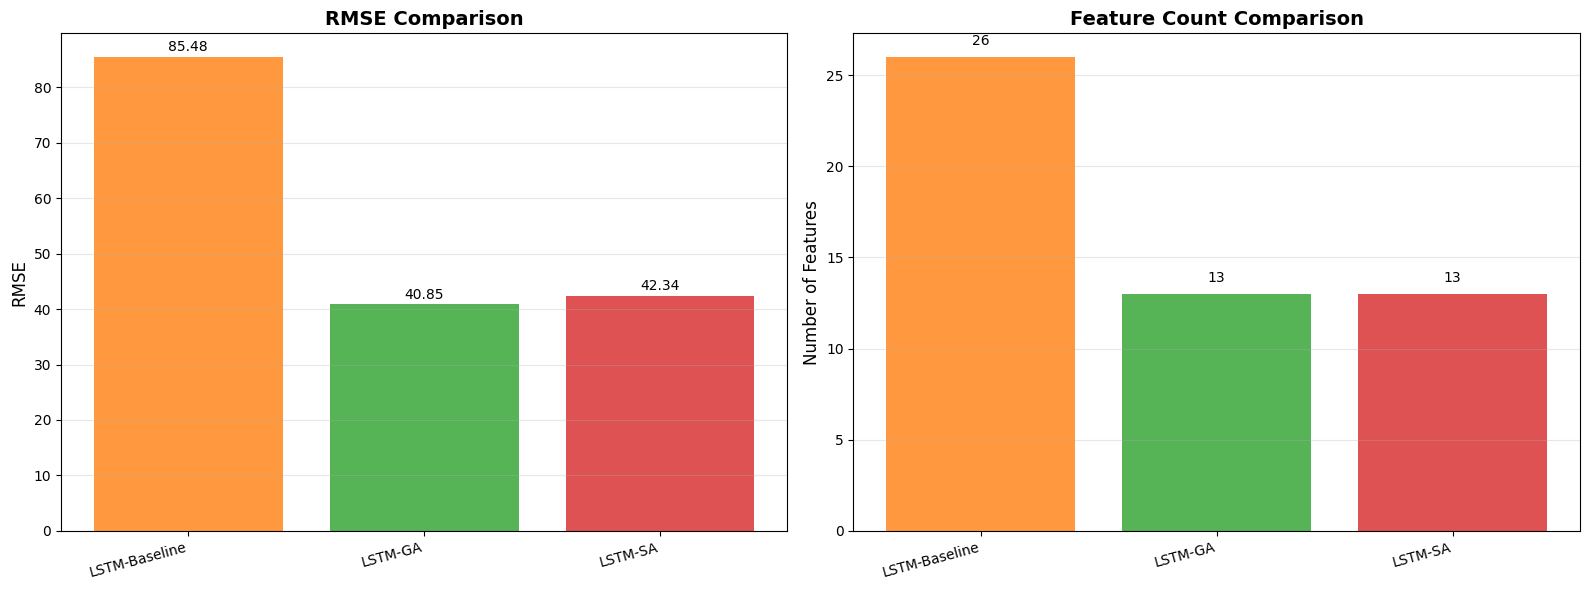

圖1: 性能對比柱狀圖


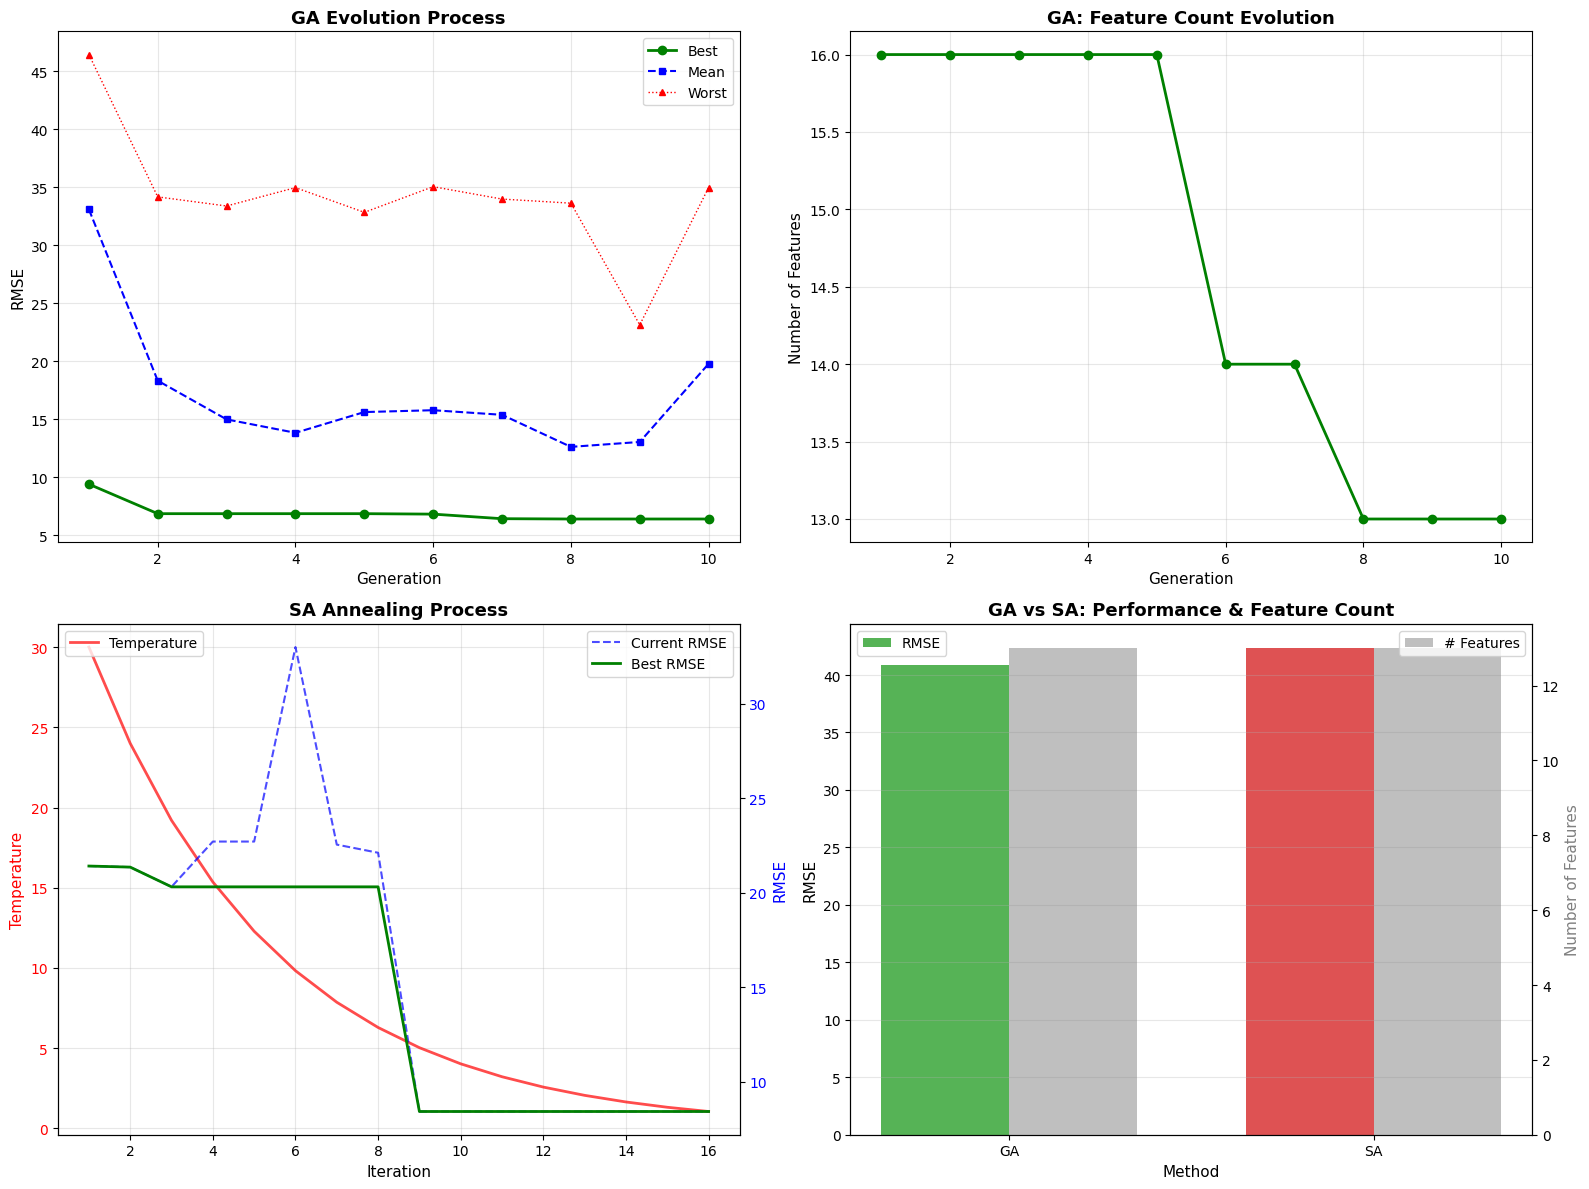

圖2: 演化過程分析


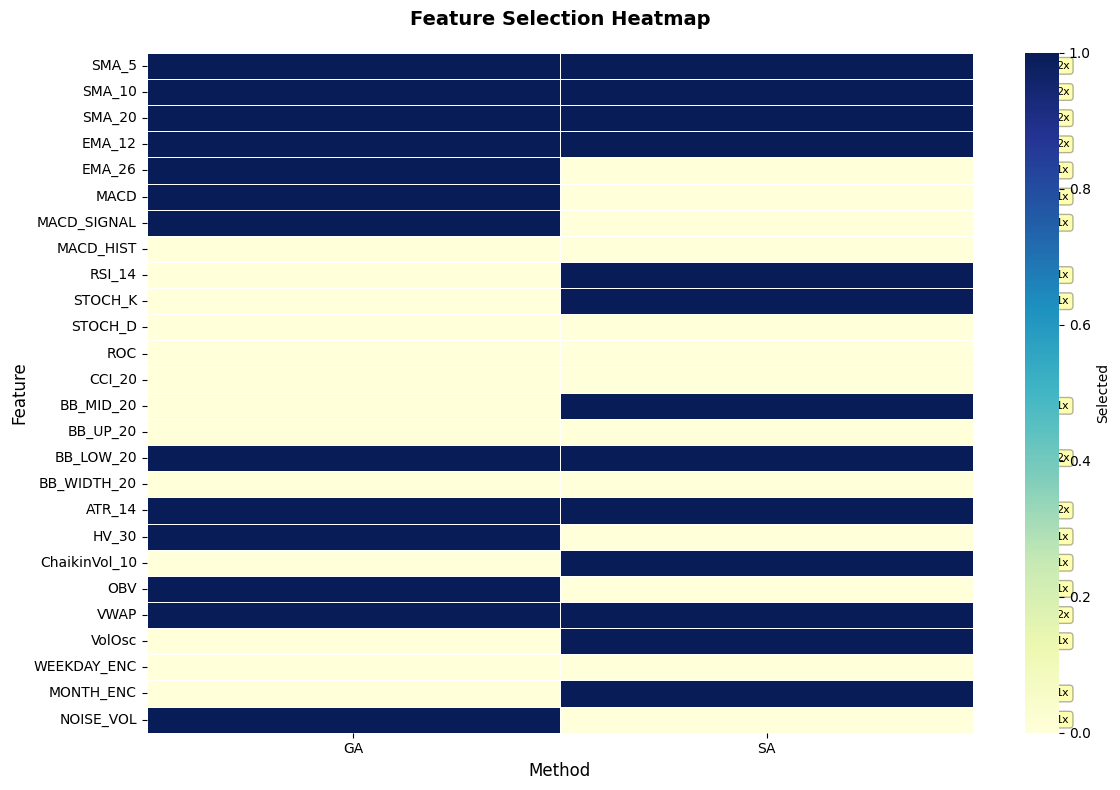

圖3: 特徵選擇熱圖

特徵選擇分析

高共識特徵 (被兩種方法都選中):
  • SMA_5: 2/2 方法選中
  • SMA_10: 2/2 方法選中
  • SMA_20: 2/2 方法選中
  • EMA_12: 2/2 方法選中
  • BB_LOW_20: 2/2 方法選中
  • ATR_14: 2/2 方法選中
  • VWAP: 2/2 方法選中

僅被一種方法選中的特徵:
  • EMA_26: 1/2 方法選中
  • MACD: 1/2 方法選中
  • MACD_SIGNAL: 1/2 方法選中
  • RSI_14: 1/2 方法選中
  • STOCH_K: 1/2 方法選中
  • BB_MID_20: 1/2 方法選中
  • HV_30: 1/2 方法選中
  • ChaikinVol_10: 1/2 方法選中
  • OBV: 1/2 方法選中
  • VolOsc: 1/2 方法選中
  • MONTH_ENC: 1/2 方法選中
  • NOISE_VOL: 1/2 方法選中

從未被選中的特徵（可能是無用特徵）:
  • MACD_HIST: 0/2 方法選中
  • STOCH_D: 0/2 方法選中
  • ROC: 0/2 方法選中
  • CCI_20: 0/2 方法選中
  • BB_UP_20: 0/2 方法選中
  • BB_WIDTH_20: 0/2 方法選中
  • WEEKDAY_ENC: 0/2 方法選中

特徵列表已保存至: ./outputs/selected_features.csv

實驗總結

📊 主要發現:
1. 最佳方法: LSTM-GA
   - RMSE: 40.845750
   - 特徵數: 13
   - 相較Baseline改進: 52.21%

2. GA vs SA比較:
   - GA RMSE: 40.845750
   - SA RMSE: 42.336209
   - GA表現較佳 (優勢: 3.52%)

3. 特徵效率:
   - Baseline特徵數: 26
   - 平均選中特徵數: 13.0
   - 特徵減少: 50.0%

4. 高共識特徵 (兩種方法都選中，推薦用於未來模型):
   1. SMA_5
   2. SMA_10
   3. SM

In [10]:
print("\n" + "="*80)
print("最終測試集評估")
print("="*80)

def final_evaluation(features, model_class, model_name):
    """
    在測試集上最終評估

    【為什麼需要最終評估？】
    1. 驗證集用於GA/SA選擇特徵
    2. 測試集用於評估真實泛化能力
    3. 避免過擬合驗證集

    【評估流程】
    1. 用選出的特徵重新訓練模型
    2. 在測試集上評估
    3. 報告RMSE和MAE
    """
    print(f"\n🔹 評估 {model_name}...")
    f_idx = [ALL_FEATURES.index(f) for f in features]

    Xtr = X_train_scaled[:, f_idx]
    Xte = X_test_scaled[:, f_idx]

    Xtr_seq, ytr_seq = create_sequences(Xtr, y_train.values, lookback_period)
    Xte_seq, yte_seq = create_sequences(Xte, y_test.values, lookback_period)

    tr_loader = DataLoader(
        TensorDataset(torch.Tensor(Xtr_seq), torch.Tensor(ytr_seq)),
        batch_size=32, shuffle=True
    )
    val_loader = DataLoader(
        TensorDataset(torch.Tensor(Xtr_seq), torch.Tensor(ytr_seq)),
        batch_size=32
    )

    model = model_class(len(features)).to(device)
    model = train_model(model, tr_loader, val_loader, epochs=epochs_final, verbose=True)
    rmse, mae = evaluate_model(model, Xte_seq, yte_seq)

    print(f"{model_name} - RMSE: {rmse:.6f}, MAE: {mae:.6f}")
    return rmse, mae

rmse_ga_trans, mae_ga_trans = final_evaluation(ga_trans_features, LSTMRegressor, "GA-LSTM")
rmse_sa_trans, mae_sa_trans = final_evaluation(sa_trans_features, LSTMRegressor, "SA-LSTM")


print("\n" + "="*80)
print("[Part 6/6] 結果分析與可視化")
print("="*80)

results_df = pd.DataFrame({
    'Method': [
        'LSTM-Baseline',
        'LSTM-GA',
        'LSTM-SA'
    ],
    'N_Features': [
        len(ALL_FEATURES),
        len(ga_trans_features),
        len(sa_trans_features)
    ],
    'RMSE': [
        rmse_trans_base,
        rmse_ga_trans,
        rmse_sa_trans
    ],
    'MAE': [
        mae_trans_base,
        mae_ga_trans,
        mae_sa_trans
    ]
})

results_df['RMSE_Improvement'] = (
    (results_df['RMSE'].iloc[0] - results_df['RMSE']) / results_df['RMSE'].iloc[0] * 100
)

print("\n" + "="*80)
print("性能比較結果")
print("="*80)
print(results_df.to_string(index=False))

results_df.to_csv(os.path.join(OUTPUT_DIR, 'results_comparison.csv'), index=False)
print(f"\n結果已保存至: {os.path.join(OUTPUT_DIR, 'results_comparison.csv')}")

print("\n生成可視化圖表...")

# 圖1: 性能對比
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = ['#ff7f0e', '#2ca02c', '#d62728']
x_pos = np.arange(len(results_df))

axes[0].bar(x_pos, results_df['RMSE'], color=colors, alpha=0.8)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(results_df['Method'], rotation=15, ha='right')
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].set_title('RMSE Comparison', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(results_df['RMSE']):
    axes[0].text(i, v + 0.5, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

axes[1].bar(x_pos, results_df['N_Features'], color=colors, alpha=0.8)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(results_df['Method'], rotation=15, ha='right')
axes[1].set_ylabel('Number of Features', fontsize=12)
axes[1].set_title('Feature Count Comparison', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(results_df['N_Features']):
    axes[1].text(i, v + 0.5, f'{int(v)}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '1_performance_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("圖1: 性能對比柱狀圖")

# 圖2: GA演化過程
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax = axes[0, 0]
generations = range(1, len(ga_trans_history['best_scores']) + 1)
ax.plot(generations, ga_trans_history['best_scores'], 'g-o', label='Best', linewidth=2, markersize=6)
ax.plot(generations, ga_trans_history['mean_scores'], 'b--s', label='Mean', linewidth=1.5, markersize=4)
ax.plot(generations, ga_trans_history['worst_scores'], 'r:^', label='Worst', linewidth=1, markersize=4)
ax.set_xlabel('Generation', fontsize=11)
ax.set_ylabel('RMSE', fontsize=11)
ax.set_title('GA Evolution Process', fontsize=13, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
ax.plot(generations, ga_trans_history['best_n_features'], 'go-', linewidth=2, markersize=6)
ax.set_xlabel('Generation', fontsize=11)
ax.set_ylabel('Number of Features', fontsize=11)
ax.set_title('GA: Feature Count Evolution', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
iterations = range(1, len(sa_trans_history['temperatures']) + 1)
ax2 = ax.twinx()
ax.plot(iterations, sa_trans_history['temperatures'], 'r-', label='Temperature', linewidth=2, alpha=0.7)
ax2.plot(iterations, sa_trans_history['current_scores'], 'b--', label='Current RMSE', linewidth=1.5, alpha=0.7)
ax2.plot(iterations, sa_trans_history['best_scores'], 'g-', label='Best RMSE', linewidth=2)
ax.set_xlabel('Iteration', fontsize=11)
ax.set_ylabel('Temperature', fontsize=11, color='r')
ax2.set_ylabel('RMSE', fontsize=11, color='b')
ax.set_title('SA Annealing Process', fontsize=13, fontweight='bold')
ax.tick_params(axis='y', labelcolor='r')
ax2.tick_params(axis='y', labelcolor='b')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
methods = ['GA', 'SA']
rmse_vals = [rmse_ga_trans, rmse_sa_trans]
feat_counts = [len(ga_trans_features), len(sa_trans_features)]
colors_comp = ['#2ca02c', '#d62728']

x = np.arange(len(methods))
width = 0.35

bars1 = ax.bar(x - width/2, rmse_vals, width, label='RMSE', color=colors_comp, alpha=0.8)
ax2 = ax.twinx()
bars2 = ax2.bar(x + width/2, feat_counts, width, label='# Features', color='gray', alpha=0.5)

ax.set_xlabel('Method', fontsize=11)
ax.set_ylabel('RMSE', fontsize=11, color='black')
ax2.set_ylabel('Number of Features', fontsize=11, color='gray')
ax.set_title('GA vs SA: Performance & Feature Count', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '2_evolution_process.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("圖2: 演化過程分析")

# 圖3: 特徵選擇熱圖
fig, ax = plt.subplots(figsize=(12, max(8, len(ALL_FEATURES) * 0.25)))

feature_matrix = np.zeros((len(ALL_FEATURES), 2))
methods = ['GA', 'SA']
feature_sets = [ga_trans_features, sa_trans_features]

for j, features in enumerate(feature_sets):
    for feat in features:
        i = ALL_FEATURES.index(feat)
        feature_matrix[i, j] = 1

sns.heatmap(feature_matrix,
            xticklabels=methods,
            yticklabels=ALL_FEATURES,
            cmap='YlGnBu',
            cbar_kws={'label': 'Selected'},
            linewidths=0.5,
            linecolor='white',
            ax=ax)

ax.set_title('Feature Selection Heatmap', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Method', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)

selection_counts = feature_matrix.sum(axis=1)
for i, count in enumerate(selection_counts):
    if count > 0:
        ax.text(2.2, i + 0.5, f'{int(count)}x', va='center', fontsize=8,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '3_feature_selection_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("圖3: 特徵選擇熱圖")

print("\n" + "="*80)
print("特徵選擇分析")
print("="*80)

feature_consensus = {}
for feat in ALL_FEATURES:
    count = sum([1 for fs in feature_sets if feat in fs])
    if count > 0:
        feature_consensus[feat] = count

feature_consensus = dict(sorted(feature_consensus.items(), key=lambda x: x[1], reverse=True))

print("\n高共識特徵 (被兩種方法都選中):")
high_consensus = {k: v for k, v in feature_consensus.items() if v == 2}
for feat, count in high_consensus.items():
    print(f"  • {feat}: {count}/2 方法選中")

print("\n僅被一種方法選中的特徵:")
mid_consensus = {k: v for k, v in feature_consensus.items() if v == 1}
for feat, count in mid_consensus.items():
    print(f"  • {feat}: {count}/2 方法選中")

print("\n從未被選中的特徵（可能是無用特徵）:")
never_selected = [f for f in ALL_FEATURES if f not in feature_consensus]
for feat in never_selected:
    print(f"  • {feat}: 0/2 方法選中")

feature_lists = pd.DataFrame({
    'GA-LSTM': pd.Series(ga_trans_features),
    'SA-LSTM': pd.Series(sa_trans_features)
})
feature_lists.to_csv(os.path.join(OUTPUT_DIR, 'selected_features.csv'), index=False)
print(f"\n特徵列表已保存至: {os.path.join(OUTPUT_DIR, 'selected_features.csv')}")

print("\n" + "="*80)
print("實驗總結")
print("="*80)

print("\n📊 主要發現:")
print(f"1. 最佳方法: {results_df.loc[results_df['RMSE'].idxmin(), 'Method']}")
print(f"   - RMSE: {results_df['RMSE'].min():.6f}")
print(f"   - 特徵數: {results_df.loc[results_df['RMSE'].idxmin(), 'N_Features']:.0f}")
print(f"   - 相較Baseline改進: {results_df.loc[results_df['RMSE'].idxmin(), 'RMSE_Improvement']:.2f}%")

ga_rmse = results_df[results_df['Method'].str.contains('GA')]['RMSE'].values[0]
sa_rmse = results_df[results_df['Method'].str.contains('SA')]['RMSE'].values[0]
print(f"\n2. GA vs SA比較:")
print(f"   - GA RMSE: {ga_rmse:.6f}")
print(f"   - SA RMSE: {sa_rmse:.6f}")
if ga_rmse < sa_rmse:
    print(f"   - GA表現較佳 (優勢: {(sa_rmse-ga_rmse)/sa_rmse*100:.2f}%)")
else:
    print(f"   - SA表現較佳 (優勢: {(ga_rmse-sa_rmse)/ga_rmse*100:.2f}%)")

baseline_feats = len(ALL_FEATURES)
avg_selected = results_df.iloc[1:]['N_Features'].mean()
print(f"\n3. 特徵效率:")
print(f"   - Baseline特徵數: {baseline_feats}")
print(f"   - 平均選中特徵數: {avg_selected:.1f}")
print(f"   - 特徵減少: {(1-avg_selected/baseline_feats)*100:.1f}%")

print(f"\n4. 高共識特徵 (兩種方法都選中，推薦用於未來模型):")
for i, (feat, count) in enumerate(list(high_consensus.items())[:15], 1):
    print(f"   {i}. {feat}")

print(f"\n5. 從未被選中的特徵 (可能是無用特徵):")
for i, feat in enumerate(never_selected[:10], 1):
    print(f"   {i}. {feat}")

print("\n" + "="*80)
print("所有結果已保存至:", OUTPUT_DIR)
print("="*80)
print("\n實驗完成！")